In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapely
from shapely.geometry import Point
from shapely.geometry import Polygon
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
import shapely
import geopandas as gpd
import geog
import folium
from folium.plugins import HeatMap

In [3]:
dFrame = pd.read_csv('../../rawdata/311/311.csv')

/home/jlrulff/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (8,17,31,32,33,34,35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
dFrame.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location'],
      dtype='object')

In [5]:
dFrame = dFrame[['Created Date', 'Closed Date', 'Agency', 'Agency Name', 'Complaint Type', 'Descriptor', 'Latitude', 'Longitude']]

In [6]:
dFrame.head()

,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Latitude,Longitude
0,05/17/2018 09:48:00 PM,05/22/2018 12:00:00 AM,DSNY,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection,40.762567,-73.802527
1,05/17/2018 06:21:00 PM,05/22/2018 12:00:00 AM,DSNY,Department of Sanitation,Request Large Bulky Item Collection,Request Large Bulky Item Collection,40.702336,-73.903409
2,06/29/2018 11:40:16 AM,07/23/2018 07:45:30 AM,DOF,Personal Exemption Unit,DOF Property - Reduction Issue,Personal SCHE Exemption,NaN,NaN
3,05/17/2018 09:32:30 AM,05/23/2018 07:09:35 PM,HPD,Department of Housing Preservation and Develop...,SAFETY,FIRE ESCAPE,40.777004,-73.977852
4,04/16/2014 11:03:20 AM,04/16/2014 09:10:07 PM,NYPD,New York City Police Department,Illegal Parking,Blocked Hydrant,40.791687,-73.974608


In [7]:
dFrame = dFrame[ (dFrame['Agency'] == 'NYPD') | ((dFrame['Agency'] == 'DEP') & (dFrame['Complaint Type'] == 'Noise'))]
dFrame = dFrame.apply(lambda row: searchForNoiseNYPD(row), axis=1)
dFrame = dFrame.dropna(subset=['Complaint Type'])
dFrame = dFrame[['Created Date', 'Closed Date', 'Descriptor', 'Latitude', 'Longitude']]
dFrame = dFrame.dropna()

In [8]:
dFrame['datetime'] = pd.to_datetime(dFrame['Created Date'])
dFrame = dFrame.set_index(['datetime'])
dFrame.sort_index(inplace=True)

In [26]:
dFrame.to_pickle('../../data/311/311.pkl')

## Spatial Filtering

In [15]:
dFrame['geometry'] = dFrame.apply(lambda row: shapely.geometry.Point((row['Longitude'], row['Latitude'])), axis=1)
noiseComplaints_geodf = gpd.GeoDataFrame(dFrame, crs={'init' : 'epsg:4326'}, geometry='geometry')
noiseComplaints_geodf = noiseComplaints_geodf.to_crs({'init':'epsg:3857'})
# noiseComplaints_geodf = noiseComplaints_geodf['2017-12-01':'2019-05-01']

In [16]:
### Consts
datapath = '../../rawdata/sensors/'
sensorFile = datapath + 'nodes.txt'

f = open(sensorFile)

for line in f:
    
    sensorID, lat, lon = line.split(' ')
    
    lat = float(lat)
    lon = float(lon)
    
    sensorDF = spatialJoin(noiseComplaints_geodf, lat, lon)
    sensorDF.to_csv('./spatialFilter/' + sensorID + '.csv')
    
f.close()

## Visualizing 311 Records

In [12]:
### Consts
datapath = '../../rawdata/sensors/'
sensorFile = datapath + 'nodes.txt'

f = open(sensorFile)

m = folium.Map(
    location=[40.73089125, -73.99758503833021],
    tiles='Stamen Toner',
    zoom_start=16
)

test = None

for line in f:
    
    sensorID, lat, lon = line.split(' ')
    
    lat = float(lat)
    lon = float(lon)
    
    filteredDF = pd.read_csv('./spatialFilter/' + sensorID + '.csv')
    filteredDF['count'] = 1
    
    test = filteredDF
    
    
    
    
#     folium.Circle(
#         radius=200,
#         location=[lat, lon],
#         popup='The Waterfront',
#         color='crimson',
#         fill=False,
#     ).add_to(m)
    
#     HeatMap(data=filteredDF[['Latitude', 'Longitude', 'count']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(m)
    
#     display(m)

In [13]:
test = test.rename(columns={'Unnamed: 0' : 'datetime'})
test = test[['Created Date', 'datetime']]
test['datetime'] = pd.to_datetime(test['datetime'])

In [14]:
test = test.set_index('datetime')

In [16]:
test = test.resample('H').agg({'Created Date': 'count'})

In [19]:
test = test['2018-01-01':'2018-12-31']

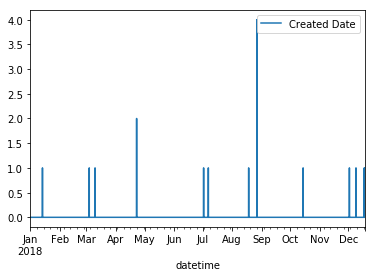

In [21]:
test.plot()

## Helper Functions

In [10]:
def searchForNoiseNYPD(row):
    if(row['Agency'] == 'NYPD'):
        complaint_type = row['Complaint Type']
        if('Noise' not in complaint_type):
            row['Complaint Type'] = np.nan
    return row

def spatialJoin(geoDataframe, lat, lon):
    d = 200 # meters
    n_points = 20
    angles = np.linspace(0, 360, n_points)
    center = shapely.geometry.Point(lon,lat)
    polygon = Polygon(geog.propagate(center, angles, d))
    
    sinpoly = gpd.GeoDataFrame(crs={'init': 'epsg:4326'})
    sinpoly = sinpoly.append({'geometry': polygon}, ignore_index=True) 
    sinpoly = sinpoly.to_crs({'init':'epsg:3857'})
    
    dataframe = gpd.tools.sjoin(geoDataframe, sinpoly, how='inner', op="within")
    
    return dataframe

    